In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.model_selection import train_test_split

# Final Class

In [ ]:
import numpy as np
import math

class MLP_Final():
    def __init__(self, num_inputs=3, num_hidden=[3,3], num_outputs=2, lr=0.1, momentum=0.5, shuffle=True, initial_weights=None, given_weights=None):  
        # parameters
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.learning_rate = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.initial_weights = initial_weights

        # keeping track of layers
        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
        self.layers = layers

        # initialize the weights
        self.weights = []
        self.weights = self.initialize_weights(self.layers) if not initial_weights else self.initialize_weights(self.layers, True, given_weights)

        # initialize activations, derivatives, and previous momentum
        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i]) 
            activations.append(a)
        self.activations = activations

        derivatives = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i], layers[i+1]))
            derivatives.append(d)
        self.derivatives = derivatives
        
        previous_momentum_change = []
        for i in range(len(self.layers) - 1):
            m = np.zeros((self.layers[i] + 1, self.layers[i+1]))
            previous_momentum_change.append(m)
        self.previous_momentum_change = previous_momentum_change


    def forward_prop(self, inputs):        
        activations = inputs
        self.activations[0] = np.append(activations, [1])

        for i, w in enumerate(self.weights):
            # calc net and add bias
            activations = np.append(activations, [1])
            net_inputs = np.dot(activations, w)

            # calc activation
            activations = self._sigmoid_function(net_inputs)
  
            # add bias
            if i < len(self.weights)-1:
              self.activations[i+1] = np.append(activations, [1])
            else:
              self.activations[i+1] = activations

        return activations

    def backpropogate(self, error, verbose=False):
        for i in reversed(range(len(self.derivatives))):         
            # output node 
            if i == len(self.derivatives) - 1:
                activations = self.activations[i+1]
            # hidden nodes
            else:
                activations = self.activations[i+1][:-1]

            delta = error * self._sigmoid_derivative(activations)
            delta_reshaped = delta.reshape(delta.shape[0], -1).T

            current_activations = self.activations[i]
            current_activations_reshaped = current_activations.reshape(current_activations.shape[0], -1)

            self.derivatives[i] = np.dot(current_activations_reshaped, delta_reshaped)

            #removing last weight associated with the bias 
            updated_weights = self.weights[i][:-1, :]
            error = np.dot(delta, updated_weights.T)

            if verbose:
                print("Derivatives for W{}: {}".format(i, self.derivatives[i]))


    def gradient_descent(self, learning_rate):
        for i in range(len(self.weights)):
            previous_momentum_change = self.previous_momentum_change[i]
            derivatives = self.derivatives[i]
            self.weights[i] += derivatives * learning_rate + self.momentum * previous_momentum_change
        
            # keep track of last change
            self.previous_momentum_change[i] = derivatives * learning_rate + self.momentum * previous_momentum_change


    def train(self, inputs, targets, epochs=None):
        # if the model had weights/deterministic
        if self.initial_weights != None:
            for i in range(epochs):
                sum_error = 0
                for (input, target) in zip(inputs, targets):    
                    # forward propogate
                    output = self.forward_prop(input)

                    # calculate error
                    error = target - output
                    
                    # backpropogation
                    self.backpropogate(error)

                    # apply gradient descent
                    self.gradient_descent(self.learning_rate)

                    sum_error += self._mse(target, output)
                
            
        # if the model is not deterministic
        else:
            #initialize variables for while loop - this is for the stopping criteria
            continue_loop = True

            validation_inputs, validation_targets, inputs, targets = self._create_validation(inputs, targets)
            
            # while loop - use num_iters in while to count
            num_iters = 0
            sum_error_validation_last = 1
            recording_validation_mse = []
            recording_train_mse = []
            recording_train_classified_correctly = []
            recording_validation_classified_correctly = []
            
            self.bestiteration = [1,0] # trying this new thing out
            self.bestWeights = []

            while continue_loop:                
                if (self.shuffle == True):
                    inputs, targets = self._shuffle(inputs, targets)
                
                # Loop through
                predicted_outputs_train = []
                sum_error_train = 0
                for (input, target) in zip(inputs, targets):    
                    # forward propogate
                    output = self.forward_prop(input)
                    predicted_outputs_train.append(output) # recording predicted outputs of train
                    sum_error_train += self._mse(output, target)

                    # calculate error
                    error = target - output
                    
                    # backpropogation
                    self.backpropogate(error) 

                    # apply gradient descent - getting rid of method
                    self.gradient_descent(self.learning_rate)

                # keep track of mse of train
                error_train = (sum_error_train/len(inputs))
                recording_train_mse.append(error_train)

                # keep track of good wieghts for stopping criteria   
                good_weights = self.weights
                


                # mse of validation
                sum_error_validation = 0
                validation_outputs_predicted = []
                for (input_val, target_val) in zip(validation_inputs, validation_targets):
                    output_val = self.forward_prop(input_val)
                    validation_outputs_predicted.append(output_val)
                    sum_error_validation += self._mse(target_val, output_val)
                
                error = (sum_error_validation/len(validation_inputs))
                recording_validation_mse.append(error)


                # classification accuracy of training
                recording_train_classified_correctly.append(self.percent_classified_binary_targets(predicted_outputs_train, targets))

                # classification accuracy of validation
                recording_validation_classified_correctly.append(self.percent_classified_binary_targets(validation_outputs_predicted, validation_targets))


                # stopping criteria
                if error < self.bestiteration[0]:
                    # print('going into loop.....')
                    noChanges = 0
                    self.bestiteration[0] = error
                    self.bestiteration[1] = num_iters
                    self.bestWeights = good_weights
                    
                else:
                    noChanges += 1
                
                num_iters += 1

                if noChanges > 5:
                    continue_loop = False

            self.record_validation_mse = recording_validation_mse
            self.record_train_mse = recording_train_mse
            
            self.record_train_classified_correctly = recording_train_classified_correctly
            self.record_validation_classified_correctly = recording_validation_classified_correctly


    def _create_validation(self, inputs, targets):
        num_targets = self.num_outputs

        together = np.concatenate((inputs, targets), axis=1)
        number_rows = together.shape[0]
        random_indeces = np.random.choice(number_rows, size=math.floor(len(together)*.15), replace=False)

        validation_array = together[random_indeces,:]

        vali_input = validation_array[:,:-num_targets]
        vali_output = validation_array[:,-num_targets:]

        testing_set = np.delete(together, random_indeces, 0)
        testing_input = testing_set[:,:-num_targets]
        testing_target = testing_set[:,-num_targets:]
        
        return vali_input, vali_output, testing_input, testing_target

    def _shuffle(self, inputs, targets):
        np_shuffled = np.concatenate((inputs, targets), axis=1)
        np.random.shuffle(np_shuffled)

        split_input = inputs.shape[1]
        split_target = targets.shape[1]
        inputs = np_shuffled[:,:split_input]
        targets = np_shuffled[:,-split_target:]

        return inputs, targets

    # adding this to score the test inputs
    def forward_prop_testing(self, inputs):        
        activations = inputs
        self.activations[0] = np.append(activations, [1])

        for i, w in enumerate(self.bestWeights):
            activations = np.append(activations, [1])
            net_inputs = np.dot(activations, w)

            # calc activation
            activations = self._sigmoid_function(net_inputs)

            # trying to fix the bias problem, but this is for sure not a good idea w/ more than 1 iteration
            if i < len(self.weights)-1:
              self.activations[i+1] = np.append(activations, [1])
            else:
              self.activations[i+1] = activations

        return activations
    
    
    # method to try to get percent classified correclty with X_test
    def percent_classified_binary_targets(self, model_outputs, y_test):
        # get correct data types
        if isinstance(model_outputs, list) == True:
            model_outputs = np.vstack(model_outputs)
        if isinstance(y_test, list) == True:
            y_test = np.vstack(y_test)

        if model_outputs.shape[1] > 1:
            model_outputs_new = np.zeros_like(model_outputs)
            model_outputs_new[np.arange(len(model_outputs)), model_outputs.argmax(1)] = 1
            model_outputs = model_outputs_new
        else:
            model_outputs = np.round(model_outputs, 0)

        correct = 0
        for (output, y) in zip(model_outputs, y_test):
            # check to see if target has multiple classes
            if model_outputs.shape[1] > 1:
                comparison_multiple_outputs = output == y
                if comparison_multiple_outputs.all() == True:
                    correct += 1
            # checking for single output class
            else:
                if output == y:
                    correct += 1
        return (correct/len(model_outputs))

    # this is a new method, didn't change anything else in this class - note: i dont think I use this
    def predict(self, inputs):
        output_list = []
        for input in inputs:
            output = self.forward_prop_testing(input)
            # print(f'output of the predict method: {output}')
            # print()
            output_list.append(output)
        # return output_list
        return np.vstack(output_list)


    # new method for getting error of test data ... but idk if this is actually necessary... refer to "perecent_classified_binary_targets() method"
    def predict_test(self, inputs, targets):
        error_test = 0
        for (input, target) in zip(inputs, targets):
            output_test = self.forward_prop(input)
            error_test += self._mse(target, output_test)
        
        error = (error_test / len(inputs))
        return error

    def _mse(self, target, output):
        return np.average((target - output)**2)

    def _sigmoid_derivative(self, x):
        return x * (1.0 - x)

    def _sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))

    def initialize_weights(self, layers, deterministic=False, given_weights=None):
        for i in range(len(layers) - 1):
            if deterministic:
                w = np.full((layers[i] + 1, layers[i+1]), given_weights)
                self.weights.append(w)
            else:
                mu, sigma = 0, 0.05 # mean and standard deviation
                w = np.random.normal(mu, sigma, size=(layers[i] + 1, layers[i+1]))
                self.weights.append(w)
        return self.weights
      
    def get_weights(self):
        return self.weights

    # ****This is only for my new method of stopping criteria****
    def get_best_weights(self):
        return self.thisbetterwork
    
    def get_best_iteration(self):
        return self.bestiteration

    def get_validationset_mse(self):
        return self.record_validation_mse

    def get_train_mse(self):
        return self.record_train_mse

    def get_validation_percent_classified(self):
        return self.record_validation_classified_correctly

    def get_train_percent_classified(self):
        return self.record_train_classified_correctly
  

My MLP model has several additional methods to the original skeleton code. In the constructor I initiate the number of inputs, hidden layers, outputs, and track the learning rate, and momentum rate. In the train method, I check to see if the model is deterministic or not. If it is, the user can specify a discrete mumber of epochs. If not, I go into my stopping criteria. 

My stopping criteria takes the validation's MSE and checks to see if each subsequent epoch either improved upon the MSE or got worse. If it imporoved, I update the weights and continued the model. If the MSE gets worse, I start a counter that allowed for 5 epochs of declining MSE until stopping.

In the training method, I reference forward_prop, backpropogate, and gradient_descent methods, which apply the MLP algorithm to each row in the data and update the weights after each row. 

# 1.1.1 Debug

In [ ]:
import pandas as pd
from scipy.io.arff import loadarff

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug_data.arff

dataset = loadarff('debug_data.arff')
df_debug = pd.DataFrame(dataset[0])
df_debug = df_debug.apply(pd.to_numeric)


X = df_debug.iloc[:,:-1].to_numpy()
y = df_debug.iloc[:,-1].to_numpy()
y = np.reshape(y, (len(y),1))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1313      0 --:--:-- --:--:-- --:--:--  1322


In [ ]:
# MLP Debug 1 output
mlp_debug = MLP_Final(X.shape[1], [4], y.shape[1], 0.1, 0.5, initial_weights=True, given_weights=0.0)


# train on dataset
inputs = X
targets = y

mlp_debug.train(inputs, targets, 10)
mlp_debug.get_weights()

[array([[-8.81779797e-05, -8.81779797e-05, -8.81779797e-05,
         -8.81779797e-05],
        [ 7.82757731e-04,  7.82757731e-04,  7.82757731e-04,
          7.82757731e-04],
        [-3.94353645e-03, -3.94353645e-03, -3.94353645e-03,
         -3.94353645e-03]]), array([[-0.01060888],
        [-0.01060888],
        [-0.01060888],
        [-0.01060888],
        [-0.02145495]])]

In [ ]:
# MLP Debug 2 outputs
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output debug_data.arff

dataset = loadarff('debug_data.arff')
df_debug2 = pd.DataFrame(dataset[0])
df_debug2 = df_debug2.apply(pd.to_numeric)

one_hot = pd.get_dummies(df_debug2['class'])

# drop 'class' and add one_hot encodings to df
df_debug2= df_debug2.drop('class', axis=1)
df_debug2 = df_debug2.join(one_hot)

X2 = df_debug2.iloc[:,:-2].to_numpy()
y2 = df_debug2.iloc[:,-2:].to_numpy()

mlp_debug2 = MLP_Final(X2.shape[1], [4], y2.shape[1], 0.1, 0.5, initial_weights=True, given_weights=0.0)

mlp_debug2.train(inputs, targets, 10)

# print weights
mlp_debug2.get_weights()



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   4191      0 --:--:-- --:--:-- --:--:--  4104


[array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
        [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
        [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]),
 array([[-0.01050642, -0.01050642],
        [-0.01050642, -0.01050642],
        [-0.01050642, -0.01050642],
        [-0.01050642, -0.01050642],
        [-0.02148778, -0.02148778]])]

# 1.1.2 Evaluation

In [ ]:
import pandas as pd
from scipy.io.arff import loadarff

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output eval_data.arff

dataset = loadarff('eval_data.arff')
df_eval = pd.DataFrame(dataset[0])
df_eval = df_eval.apply(pd.to_numeric)

X = df_eval.iloc[:,:-1].to_numpy()
y = df_eval.iloc[:,-1].to_numpy()
y = np.reshape(y, (len(y),1))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   321k      0 --:--:-- --:--:-- --:--:--  321k


In [ ]:
mlp_eval = MLP_Final(X.shape[1], [4], y.shape[1], 0.1, 0.5, initial_weights=True, given_weights=0.0)

mlp_eval.train(X, y, 10)

# print weights
mlp_eval.get_weights()

[array([[ 1.30932366,  1.30932366,  1.30932366,  1.30932366],
        [ 0.80601033,  0.80601033,  0.80601033,  0.80601033],
        [ 0.92744187,  0.92744187,  0.92744187,  0.92744187],
        [ 0.22165294,  0.22165294,  0.22165294,  0.22165294],
        [-1.45313731, -1.45313731, -1.45313731, -1.45313731]]),
 array([[-1.88512443],
        [-1.88512443],
        [-1.88512443],
        [-1.88512443],
        [ 4.57969955]])]

# 2 Backpropogation on the Iris Classification Problem

In [ ]:
import pandas as pd
from scipy.io.arff import loadarff
import numpy as np

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

dataset = loadarff('iris.arff')
df_iris = pd.DataFrame(dataset[0])

# cleaning iris
str_df = df_iris.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_iris[col] = str_df[col]

dummies = pd.get_dummies(df_iris['class'])
df_iris_new = df_iris.drop(columns=['class'])

df_iris = pd.concat([df_iris_new,dummies],axis='columns')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k


In [ ]:
from sklearn.model_selection import train_test_split

X_iris = df_iris.iloc[:,:-3].to_numpy()
y_iris = df_iris.iloc[:,-3:].to_numpy()

# split data up in train and test
x_train, x_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.20)


mlp_iris = MLP_Final(X_iris.shape[1], [X_iris.shape[1]*2], y_iris.shape[1], .1, 0.5)

# train on training data
inputs = x_train
targets = y_train

# train model
mlp_iris.train(inputs, targets)

# get validation MSE
mse_iris_val = mlp_iris.get_validationset_mse()
mse_iris_train = mlp_iris.get_train_mse()

MSE (mean squared error) over epochs from the training set and validation set

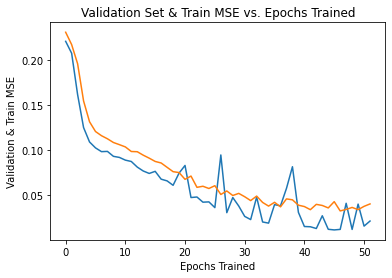

In [ ]:
import matplotlib.pyplot as plt




plt.plot(np.arange(len(mse_iris_val)), mse_iris_val, label="Validation MSE")
plt.plot(np.arange(len(mse_iris_train)), mse_iris_train, label="Train MSE")


plt.title("Validation Set & Train MSE vs. Epochs Trained")
plt.xlabel("Epochs Trained")
plt.ylabel("Validation & Train MSE")
plt.show()

Classification accuracy (% classified correctly) over epochs from the training set and validation set

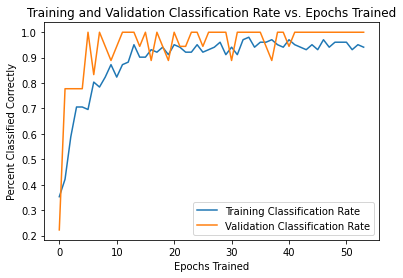

In [ ]:
training_classified = mlp_iris.get_train_percent_classified()
validation_classified = mlp_iris.get_validation_percent_classified()

plt.plot(np.arange(len(training_classified)), training_classified, label="Training Classification Rate")
plt.plot(np.arange(len(validation_classified)), validation_classified, label="Validation Classification Rate")

plt.title("Training and Validation Classification Rate vs. Epochs Trained")
plt.xlabel("Epochs Trained")
plt.ylabel("Percent Classified Correctly")
plt.legend()
plt.show()

Test Accuracy

In [ ]:
# X_test
test_outputs = mlp_iris.predict(x_test)

# Get test accuracy
test_accuracy = mlp_iris.percent_classified_binary_targets(test_outputs, y_test)
print(f'Test accuracy: {100*round(test_accuracy,4)}%')

Test accuracy: 96.67%


### Notes on section 2

My test accuracy for the Iris dataset was 96.67%. I used a LR of 0.1, an 80/20 split, a validation that used 15% of the training data, graphed the MSE of the train and validation, and finally graphed the classification rate of the train and validation.

My stopping criteria took the validation's MSE and checked to see if each subsequent epoch either improved upon the MSE or got worse. If it imporoved, I kept updating the weights and continued the model. If the MSE got worse, I started a counter that allowed for 5 epochs of declining MSE until stopping. Once the model stops iterating through epochs, I take the weights from the best model (5 epochs previous to the from the time of stopping).

# 3 Working with Vowel Dataset - Learning Rate

In [ ]:
import pandas as pd
from scipy.io.arff import loadarff
import numpy as np
from sklearn.model_selection import train_test_split

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff

dataset = loadarff('vowel.arff')
df_vowel = pd.DataFrame(dataset[0])

# clean vowel
str_df = df_vowel.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_vowel[col] = str_df[col]


# create dummy for sex
dummies_vowel = pd.get_dummies(df_vowel['Sex'])
# dummies_vowel.drop(columns=['Female'], inplace=True) # i think i need to drop one of the dummy columns... actually might just be for linear regression
df_vowel_new = df_vowel.drop(columns=['Sex'])

df_vowel = pd.concat([df_vowel_new,dummies_vowel], axis='columns')

# create dummy for class
dummies_class = pd.get_dummies(df_vowel['Class'])
df_vowel_new = df_vowel.drop(columns=['Class'])

df_vowel = pd.concat([df_vowel_new,dummies_class], axis='columns')

df_vowel.drop(['Train or Test', 'Speaker Number'], axis=1, inplace=True)

X = df_vowel.iloc[:,:-11].to_numpy()
y = df_vowel.iloc[:,-11:].to_numpy()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91402  100 91402    0     0   417k      0 --:--:-- --:--:-- --:--:--  417k


In [ ]:
# random split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates1 = MLP_Final(x_train.shape[1], [x_train.shape[1]*2], y_train.shape[1], 1.1, 0.5)

                                        
# train model
mlp_vowel_learning_rates1.train(x_train, y_train)

# get mse
mse_lr1 = mlp_vowel_learning_rates1.get_validationset_mse()
mse_lr1

In [ ]:
# random split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates2 = MLP_Final(x_train.shape[1], [x_train.shape[1]*2], y_train.shape[1], .822, 0.5)

                                        
# train model
mlp_vowel_learning_rates2.train(x_train, y_train)

# get mse
mse_lr2 = mlp_vowel_learning_rates2.get_validationset_mse()
mse_lr2

In [ ]:
# random split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates3 = MLP_Final(x_train.shape[1], [x_train.shape[1]*2], y_train.shape[1], .622, 0.5)

                                        
# train model
mlp_vowel_learning_rates3.train(x_train, y_train)

# get mse
mse_lr3 = mlp_vowel_learning_rates3.get_validationset_mse()
mse_lr3

In [ ]:
# random split
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates4 = MLP_Final(x_train4.shape[1], [x_train4.shape[1]*2], y_train4.shape[1], .499, 0.5)

                                        
# train model
mlp_vowel_learning_rates4.train(x_train4, y_train4)

# get mse
mse_lr4 = mlp_vowel_learning_rates4.get_validationset_mse()
mse_lr4

In [ ]:
# random split
x_train5, x_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates5 = MLP_Final(x_train5.shape[1], [x_train5.shape[1]*2], y_train5.shape[1], .211, 0.5)

                                        
# train model
mlp_vowel_learning_rates5.train(x_train5, y_train5)

# get mse
mse_lr5 = mlp_vowel_learning_rates5.get_validationset_mse()
mse_lr5

In [ ]:
# random split
x_train6, x_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates6 = MLP_Final(x_train6.shape[1], [x_train6.shape[1]*2], y_train6.shape[1], .15, 0.5)

                                        
# train model
mlp_vowel_learning_rates6.train(x_train6, y_train6)

# get mse
mse_lr6 = mlp_vowel_learning_rates6.get_validationset_mse()
mse_lr6

In [ ]:
# random split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# call model
mlp_vowel_learning_rates7 = MLP_Final(x_train.shape[1], [x_train.shape[1]*2], y_train.shape[1], .05, 0.5)

                                        
# train model
mlp_vowel_learning_rates7.train(x_train, y_train)

# get mse
mse_lr7 = mlp_vowel_learning_rates7.get_validationset_mse()
mse_lr7

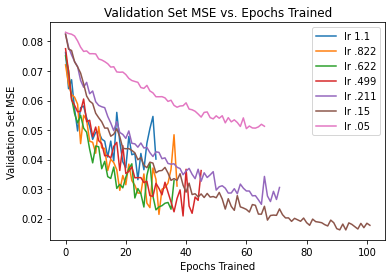

In [ ]:
# all together

plt.plot(np.arange(len(mse_lr1)), mse_lr1, label="lr 1.1")
plt.plot(np.arange(len(mse_lr2)), mse_lr2, label="lr .822")
plt.plot(np.arange(len(mse_lr3)), mse_lr3, label="lr .622")
plt.plot(np.arange(len(mse_lr4)), mse_lr4, label="lr .499")
plt.plot(np.arange(len(mse_lr5)), mse_lr5, label="lr .211")
plt.plot(np.arange(len(mse_lr6)), mse_lr6, label="lr .15")
plt.plot(np.arange(len(mse_lr7)), mse_lr7, label="lr .05")

plt.title("Validation Set MSE vs. Epochs Trained")
plt.xlabel("Epochs Trained")
plt.ylabel("Validation Set MSE")
plt.legend()
plt.show()

Best test set accuracy of Vowel dataset - testing 3 different learning rates


In [ ]:
# Test on lr of .15

test_outputs = mlp_vowel_learning_rates6.predict(x_test6)

test_accuracy = mlp_vowel_learning_rates6.percent_classified_binary_targets(test_outputs, y_test6)
print(f'Test accuracy on learning rate of 0.15: {100*round(test_accuracy,4)}%')

Test accuracy: 87.37%


In [ ]:
# test on lr of .211

test_outputs = mlp_vowel_learning_rates5.predict(x_test5)

test_accuracy = mlp_vowel_learning_rates5.percent_classified_binary_targets(test_outputs, y_test5)
print(f'Test accuracy on learning rate of 0.211: {100*round(test_accuracy,3)}%')

Test accuracy on learning rate of 0.211: 76.8%


In [ ]:
# test on lr of .499

test_outputs = mlp_vowel_learning_rates4.predict(x_test5)

test_accuracy = mlp_vowel_learning_rates4.percent_classified_binary_targets(test_outputs, y_test5)
print(f'Test accuracy on learning rate of 0.499: {100*round(test_accuracy,3)}%')

Test accuracy on learning rate of 0.499: 81.8%


# 3.1 Intuition

### Various effects of learning rate
I tested 7 different learning rates. I started at 1.1 and went down to 0.05. I 
stopped after 0.05 because it performed worse in MSE than my previous learning rate of 0.15. Learning rates that are too high (i.e. 1.1 or 0.852) don't allow the MLP model to converge because the steps are too large. Conversely, learning rates that are too low (i.e. 0.05) take much longer to converge, with no accuracy improvement. With my stopping criteria (i.e. if validation set does not improve over 5 consecutive epochs, stop iterating through model and take best weights) the small weight of 0.05 actually performed the worst in MSE among all my learning rates.
 



### Discussing vowel dataset and iris dataset


All else equal, the vowel dataset is a more difficult problem than the Iris dataset because there are more labels to predict in the vowel dataset than the iris (11 in the Vowel vs. 3 in the Iris). However, there are more data in the Vowel dataset than the Iris dataset, so my hypothesis was to expect both models to return a similar accuarracy, with the Iris slightly outperforming the Vowel.

The best way for me to compare the models was to see the accuracy relative to the baseline. Given the baseline accuracies, the models performed relatively well with both datasets, but the Vowel model beat the Iris when looking at increased accuracy relative to the baseline. The baseline accuracy of the Iris dataset is 33%, since there are 3 labels, and the baseline accuracy for the Vowel dataset is around 9%, since there are 11 labels. My test accuracy in the Iris dataset was 96.67%, or approximately a 63% imporovement over the baseline. My best test accuracy on the Vowel dataset was 87.37% (with a learnig rate of 0.15), or a 78% improvement from baseline. So although the Iris model was more accurate, the Vowel model performed better relative to its baseline accuarcy. 

For the vowel dataset, I chose to use all the input features except train/test and speaker. I did chose to include gender (although at first it seemed potentially irrelevant) because I reasoned that the gender of the speaker would likely have some impact on the vowel phoneme output, since on average the tones of males and females differ.

# 3.2 Working with the Vowel Dataset - Hidden Layer Nodes

In [ ]:
# Using learning rate of 0.15 and 1 hidden node

# random split of vowel data
x_train_hidden1, x_test_hidden1, y_train_hidden1, y_test_hidden1 = train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden1 = MLP_Final(x_train_hidden1.shape[1], [1], y_train_hidden1.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden1.train(x_train_hidden1, y_train_hidden1)

# get mse
mse_hidden1_val = mlp_vowel_hidden1.get_validationset_mse()
mse_hidden1_train = mlp_vowel_hidden1.get_train_mse()

In [ ]:
# Using learning rate of 0.15 and 2 hidden node

# random split of vowel data
x_train_hidden2, x_test_hidden2, y_train_hidden2, y_test_hidden2 = train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden2 = MLP_Final(x_train_hidden2.shape[1], [2], y_train_hidden2.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden2.train(x_train_hidden2, y_train_hidden2)

# get mse
mse_hidden2_val = mlp_vowel_hidden2.get_validationset_mse()
mse_hidden2_train = mlp_vowel_hidden2.get_train_mse()

In [ ]:
# Using learning rate of 0.15 and 4 hidden node

# random split of vowel data
x_train_hidden3, x_test_hidden3, y_train_hidden3, y_test_hidden3 = train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden3 = MLP_Final(x_train_hidden3.shape[1], [4], y_train_hidden3.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden3.train(x_train_hidden3, y_train_hidden3)

# get mse
mse_hidden3_val = mlp_vowel_hidden3.get_validationset_mse()
mse_hidden3_train = mlp_vowel_hidden3.get_train_mse()

In [ ]:
# Using learning rate of 0.15 and 8 hidden nodes

# random split of vowel data
x_train_hidden4, x_test_hidden4, y_train_hidden4, y_test_hidden4 = train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden4 = MLP_Final(x_train_hidden4.shape[1], [8], y_train_hidden4.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden4.train(x_train_hidden4, y_train_hidden4)

# get mse
mse_hidden4_val = mlp_vowel_hidden4.get_validationset_mse()
mse_hidden4_train = mlp_vowel_hidden4.get_train_mse()

In [ ]:
# Using learning rate of 0.15 and 16 hidden nodes

# random split of vowel data
x_train_hidden5, x_test_hidden5, y_train_hidden5, y_test_hidden5 = train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden5 = MLP_Final(x_train_hidden5.shape[1], [16], y_train_hidden5.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden5.train(x_train_hidden5, y_train_hidden5)

# get mse
mse_hidden5_val = mlp_vowel_hidden5.get_validationset_mse()
mse_hidden5_train = mlp_vowel_hidden5.get_train_mse()

In [ ]:
# Using learning rate of 0.15 and 32 hidden nodes

# random split of vowel data
x_train_hidden6, x_test_hidden6, y_train_hidden6, y_test_hidden6= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden6 = MLP_Final(x_train_hidden6.shape[1], [32], y_train_hidden6.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden6.train(x_train_hidden6, y_train_hidden6)

# get mse
mse_hidden6_val = mlp_vowel_hidden6.get_validationset_mse()
mse_hidden6_train = mlp_vowel_hidden6.get_train_mse()


In [ ]:
# Using learning rate of 0.15 and 64 hidden nodes

# random split of vowel data
x_train_hidden7, x_test_hidden7, y_train_hidden7, y_test_hidden7= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_hidden7 = MLP_Final(x_train_hidden7.shape[1], [64], y_train_hidden7.shape[1], 0.15, 0.5)
    
# train model
mlp_vowel_hidden7.train(x_train_hidden7, y_train_hidden7)

# get mse
mse_hidden7_val = mlp_vowel_hidden7.get_validationset_mse()
mse_hidden7_train = mlp_vowel_hidden7.get_train_mse()

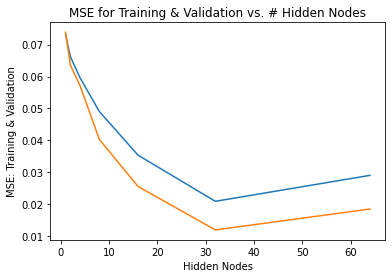

In [ ]:
# creating graph to show results of the hidden nodes test
import matplotlib.pyplot as plt

# plt.scatter([1, 2, 4, 8, 16, 32, 64], 
#          [mse_hidden1[-1], mse_hidden2[-1], mse_hidden3[-1], mse_hidden4[-1], mse_hidden5[-1], mse_hidden6[-1], mse_hidden7[-1]])

plt.plot([1, 2, 4, 8, 16, 32, 64], 
         [mse_hidden1_val[-1], mse_hidden2_val[-1], mse_hidden3_val[-1], mse_hidden4_val[-1], mse_hidden5_val[-1], mse_hidden6_val[-1], 
          mse_hidden7_val[-1]], label="Validation")

plt.plot([1, 2, 4, 8, 16, 32, 64], 
         [mse_hidden1_train[-1], mse_hidden2_train[-1], mse_hidden3_train[-1], mse_hidden4_train[-1], mse_hidden5_train[-1], mse_hidden6_train[-1], 
          mse_hidden7_train[-1]], label="Train")

plt.title("MSE for Training & Validation vs. # Hidden Nodes")
plt.xlabel("Hidden Nodes")
plt.ylabel("MSE: Training & Validation")
plt.show()

In [ ]:
# Printing the final test set accuracy for each node
test_outputs = mlp_vowel_hidden1.predict(x_test_hidden1)
test_accuracy_h1 = mlp_vowel_hidden1.percent_classified_binary_targets(test_outputs, y_test_hidden1)
print(f'Test accuracy of 1 hidden node: {100*round(test_accuracy_h1,3)}%')

test_outputs = mlp_vowel_hidden2.predict(x_test_hidden2)
test_accuracy_h1 = mlp_vowel_hidden2.percent_classified_binary_targets(test_outputs, y_test_hidden2)
print(f'Test accuracy of 2 hidden nodes: {100*round(test_accuracy_h1,3)}%')

test_outputs = mlp_vowel_hidden3.predict(x_test_hidden3)
test_accuracy_h1 = mlp_vowel_hidden3.percent_classified_binary_targets(test_outputs, y_test_hidden3)
print(f'Test accuracy of 4 hidden nodes: {100*round(test_accuracy_h1,3)}%')

test_outputs = mlp_vowel_hidden4.predict(x_test_hidden4)
test_accuracy_h1 = mlp_vowel_hidden4.percent_classified_binary_targets(test_outputs, y_test_hidden4)
print(f'Test accuracy of 8 hidden nodes: {100*round(test_accuracy_h1,2)}%')

test_outputs = mlp_vowel_hidden5.predict(x_test_hidden5)
test_accuracy_h1 = mlp_vowel_hidden5.percent_classified_binary_targets(test_outputs, y_test_hidden5)
print(f'Test accuracy of 16 hidden nodes: {100*round(test_accuracy_h1,2)}%')

test_outputs = mlp_vowel_hidden6.predict(x_test_hidden6)
test_accuracy_h1 = mlp_vowel_hidden6.percent_classified_binary_targets(test_outputs, y_test_hidden6)
print(f'Test accuracy of 32 hidden nodes: {100*round(test_accuracy_h1,3)}%')

test_outputs = mlp_vowel_hidden7.predict(x_test_hidden6)
test_accuracy_h1 = mlp_vowel_hidden7.percent_classified_binary_targets(test_outputs, y_test_hidden6)
print(f'Test accuracy of 64 hidden nodes: {100*round(test_accuracy_h1,3)}%')


Test accuracy of 1 hidden node: 22.2%
Test accuracy of 2 hidden nodes: 35.9%
Test accuracy of 4 hidden nodes: 44.9%
Test accuracy of 8 hidden nodes: 70.0%
Test accuracy of 16 hidden nodes: 69.0%
Test accuracy of 32 hidden nodes: 88.4%
Test accuracy of 64 hidden nodes: 91.4%


After doubling the hidden nodes in each test and stopping after the accuracy stopped improving, I found that 34 hidden nodes performed the best with MSE. This confirmed my general intuition that a reasonable size of hidden layers is about double the number of features. Too few hidden nodes leads to underfitting, while too many nodes makes learning slower and can lead to overfit.

My test accuracy showed that 64 nodes actually performed the best out all all of my 7 tests.

# 3.3 Working with the Vowel Dataset - Momentum

In [ ]:
# Using learning rate of 0.15, 32 hidden nodes, and a momentum of 0.9

# random split of vowel data
x_train_m1, x_test_m1, y_train_m1, y_test_m1= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_m1 = MLP_Final(x_train_m1.shape[1], [32], y_train_m1.shape[1], 0.15, 0.9)

mlp_vowel_m1.train(x_train_m1, y_train_m1)

# get mse
epochs_m1 = len(mlp_vowel_m1.get_validationset_mse())
print(epochs_m1)
print()

# test
test_outputs = mlp_vowel_m1.predict(x_test_m1)
test_accuracy_m1 = mlp_vowel_m1.percent_classified_binary_targets(test_outputs, y_test_m1)
print(f'Test accuracy of momentum of 0.9: {100*round(test_accuracy_m1,3)}%')

40

Test accuracy of momentum of 0.9: 77.27000000000001%


In [ ]:
# Using learning rate of 0.15, 32 hidden nodes, and a momentum of 0.75

# random split of vowel data
x_train_m2, x_test_m2, y_train_m2, y_test_m2= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_m2 = MLP_Final(x_train_m2.shape[1], [32], y_train_m2.shape[1], 0.15, 0.75)

mlp_vowel_m2.train(x_train_m2, y_train_m2)

# get mse
epochs_m2 = len(mlp_vowel_m2.get_validationset_mse())
print(epochs_m2)
print()

# test
test_outputs = mlp_vowel_m2.predict(x_test_m1)
test_accuracy_m2 = mlp_vowel_m2.percent_classified_binary_targets(test_outputs, y_test_m1)
print(f'Test accuracy of momentum of 0.75: {100*round(test_accuracy_m2,3)}%')

37

Test accuracy of momentum of 0.9: 83.8%


In [ ]:
# Using learning rate of 0.15, 32 hidden nodes, and a momentum of 0.65

# random split of vowel data
x_train_m3, x_test_m3, y_train_m3, y_test_m3= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_m3 = MLP_Final(x_train_m3.shape[1], [32], y_train_m3.shape[1], 0.15, 0.65)

mlp_vowel_m3.train(x_train_m3, y_train_m3)

# get mse
epochs_m3 = len(mlp_vowel_m3.get_validationset_mse())
print(epochs_m3)
print()

# test
test_outputs = mlp_vowel_m3.predict(x_test_m1)
test_accuracy_m3 = mlp_vowel_m3.percent_classified_binary_targets(test_outputs, y_test_m1)
print(f'Test accuracy of momentum of 0.65: {100*round(test_accuracy_m3,3)}%')

78

Test accuracy of momentum of 0.65: 91.9%


In [ ]:
# Using learning rate of 0.15, 32 hidden nodes, and a momentum of 0.5

# random split of vowel data
x_train_m4, x_test_m4, y_train_m4, y_test_m4= train_test_split(X, y, test_size=0.20)

# call model 
mlp_vowel_m4 = MLP_Final(x_train_m4.shape[1], [32], y_train_m4.shape[1], 0.15, 0.5)

mlp_vowel_m4.train(x_train_m4, y_train_m4)

# get mse
epochs_m4 = len(mlp_vowel_m4.get_validationset_mse())
print(epochs_m4)
print()

# test
test_outputs = mlp_vowel_m4.predict(x_test_m1)
test_accuracy_m4 = mlp_vowel_m4.percent_classified_binary_targets(test_outputs, y_test_m1)
print(f'Test accuracy of momentum of 0.5: {100*round(test_accuracy_m4,3)}%')

78

Test accuracy of momentum of 0.5: 86.4%


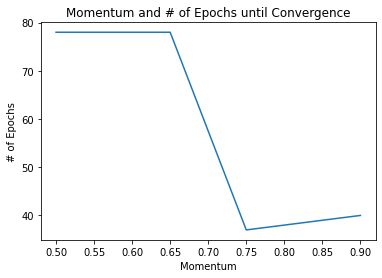

In [ ]:
# creating graph to show results of the hidden nodes test
import matplotlib.pyplot as plt

# plt.scatter([1, 2, 4, 8, 16, 32, 64], 
#          [mse_hidden1[-1], mse_hidden2[-1], mse_hidden3[-1], mse_hidden4[-1], mse_hidden5[-1], mse_hidden6[-1], mse_hidden7[-1]])

plt.plot([.9, .75, .65, .5], 
         [epochs_m1, epochs_m2, epochs_m3, epochs_m4])

plt.title("Momentum and # of Epochs until Convergence")
plt.xlabel("Momentum")
plt.ylabel("# of Epochs")
plt.show()

As the graph above shows, models with higher momentum values converged quicker. However, I did find in my 4 differnt tests that a high momentum, like 0.9, had a lower accuracy on the testing data. The most accurate model used a momentum of .65 and took as many epochs to converge as the model with a momentum of .5. 

The direction of the graph validates my conceptual understanding of momentum: that since momentum acts as a speed-up modification to the learning rate, higher momentum values will result in models that converge quicker.

# 4.1 Scikit Learn MLP Classifier on Iris and Vowel Datasets

Loading in data

In [ ]:
# Loading vowel dataset
import pandas as pd
from scipy.io.arff import loadarff
import numpy as np
from sklearn.model_selection import train_test_split

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff --output vowel.arff

dataset = loadarff('vowel.arff')
df_vowel = pd.DataFrame(dataset[0])

# clean vowel
str_df = df_vowel.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

for col in str_df:
    df_vowel[col] = str_df[col]


# create dummy for sex
dummies_vowel = pd.get_dummies(df_vowel['Sex'])
df_vowel_new = df_vowel.drop(columns=['Sex'])

df_vowel = pd.concat([df_vowel_new,dummies_vowel], axis='columns')

# create dummy for class
dummies_class = pd.get_dummies(df_vowel['Class'])
df_vowel_new = df_vowel.drop(columns=['Class'])

df_vowel = pd.concat([df_vowel_new,dummies_class], axis='columns')

df_vowel.drop(['Train or Test', 'Speaker Number'], axis=1, inplace=True)

X = df_vowel.iloc[:,:-11].to_numpy()
y = df_vowel.iloc[:,-11:].to_numpy()

Comparing sk_learn to my model using a learning rate of 0.15, 32 hidden nodes, and momentum of 0.65

In [ ]:
# Comparing accuracy to my model given best learning rate (.15), hidden nodes (32), and momentum (.65)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk = MLPClassifier(learning_rate='constant', learning_rate_init=0.15, hidden_layer_sizes=(32,), momentum=0.65, activation='logistic', max_iter=5000,
                       n_iter_no_change=5, solver='sgd').fit(X_train, y_train)

accuracy = mlp_sk.score(X_test, y_test)
epochs = mlp_sk.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')


Test accuracy: 82.8%
Number of epochs: 1542


In [ ]:
# my model for same parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_vowel = MLP_Final(X_train.shape[1], [32], y_train.shape[1], 0.15, 0.65)

mlp_vowel.train(X_train, y_train)

# get mse
epochs = len(mlp_vowel_m1.get_validationset_mse())


# test
test_outputs = mlp_vowel.predict(X_test)
test_accuracy = mlp_vowel.percent_classified_binary_targets(test_outputs, y_test)
print(f'Test accuracy: {100*round(test_accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 78.8%
Number of epochs: 40


Trying different hyperparameters of sk_learn and commenting on effect

In [ ]:
# Selecting different hyperparameters from scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk_hp = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.1, hidden_layer_sizes=(34),
                       momentum=0.65, n_iter_no_change=10, solver='sgd', nesterovs_momentum=True, max_iter=5000,
                       tol=1e-4, activation='logistic').fit(X_train, y_train)

accuracy = mlp_sk_hp.score(X_test, y_test)
epochs = mlp_sk_hp.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 82.3%
Number of epochs: 4272


In [ ]:
# Selecting different hyperparameters from scikit learn - testing differnt activations: relu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk_hp = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.1, hidden_layer_sizes=(34),
                       momentum=0.65, solver='sgd', nesterovs_momentum=True, max_iter=5000,
                       tol=1e-4, activation='relu').fit(X_train, y_train)

accuracy = mlp_sk_hp.score(X_test, y_test)
epochs = mlp_sk_hp.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 74.7%
Number of epochs: 1090


In [ ]:
# Selecting different hyperparameters from scikit learn - testing differnt activations: tanh
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk_hp = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.1, hidden_layer_sizes=(34),
                       momentum=0.65, solver='sgd', nesterovs_momentum=True, max_iter=5000,
                       tol=1e-4, activation='tanh').fit(X_train, y_train)

accuracy = mlp_sk_hp.score(X_test, y_test)
epochs = mlp_sk_hp.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 79.3%
Number of epochs: 1306


Testing Nesterovs momentum

In [ ]:
# Selecting different hyperparameters from scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk_hp = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.1, hidden_layer_sizes=(34),
                       momentum=0.65, n_iter_no_change=10, solver='sgd', nesterovs_momentum=True, max_iter=5000,
                       tol=1e-4, activation='logistic').fit(X_train, y_train)

accuracy = mlp_sk_hp.score(X_test, y_test)
epochs = mlp_sk_hp.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 83.3%
Number of epochs: 4221


In [ ]:
# Selecting different hyperparameters from scikit learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp_sk_hp = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.1, hidden_layer_sizes=(34),
                       momentum=0.65, n_iter_no_change=10, solver='sgd', nesterovs_momentum=False, max_iter=5000,
                       tol=1e-4, activation='logistic').fit(X_train, y_train)

accuracy = mlp_sk_hp.score(X_test, y_test)
epochs = mlp_sk_hp.n_iter_

print(f'Test accuracy: {100*round(accuracy,3)}%')
print(f'Number of epochs: {epochs}')

Test accuracy: 84.3%
Number of epochs: 4474


Using the sklearn model with all the same hyperparameters as my model, I got a model with approximately 4% less accuracy (78.8% in my model compared with 82.8% in the sklearn model) in much fewer epochs. The sklearn model ran 1542 epochs and my model ran only 40. This difference is most likely due to slight variations in stopping criteria. 

I then used the sklearn model to try out other various hyper parameters. I used the same model with different activation fucntions. I tried logistic, tanh, and relu. The result is that the logistic model performed the best. I also tried out diff depths of hidden layers. When I added more than 1 hidden layer, the accuracy of the model decreased significanlty. I also tried nesterovs_momentum on relative models and found the model without Nesterov's momentum was 1% more accurate.

I also found that models with learning rates < .01 performed worse than models with learning rates between .01 and .5.

# 4.2 Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid/random search

In [ ]:
learning_rates = [1.1,.9,.85,.8,.75,.65,.5,.35,.225,.1,.05,.01]
hidden_nodes = [1, 2, 4, 8, 10, 16, 20, 30, 40, 60, 80, 100, 120, 150, 175, 200, 250]
momentum = [.9,.8,.75,.7,.65,.6,.55,.5,.45,.4,.3,.2,.1,.05]
best_accuracy = []
num_epochs = []
combination_list = []

for lr in learning_rates:
  for h in hidden_nodes:
    for m in momentum:

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      mlp_grid = MLPClassifier(learning_rate='constant', learning_rate_init=lr, hidden_layer_sizes=(h,), momentum=m,
                               activation='logistic').fit(X_train, y_train)
      accuracy = mlp_grid.score(X_test, y_test)
      epochs = mlp_grid.n_iter_  
      
      best_accuracy.append(accuracy)
      num_epochs.append(epochs)
      combinations = [lr, h, m]
      combination_list.append(combinations)




In [ ]:
best_accuracy_grid = max(best_accuracy)
best_accuracy_index = best_accuracy.index(best_accuracy_grid)
final_combination = combination_list[best_accuracy_index]

print(f'The best test set accuracy from grid search was {round(best_accuracy_grid,3)*100}%')
print(f'This used the combination of a learning rate of {final_combination[0]}, {final_combination[1]} layers, and a momentum value of {final_combination[2]}')

The best test set accuracy from grid search was 93.4%
This used the combination of a learning rate of 0.05, 150 layers, and a momentum value of 0.5


After trying all the combinations of learning rates, hidden nodes, and momentum values, the model that performed the best used a learning rate of .05, 150 hidden layers, and a momentum of 0.5. These values were different thatn the best parameters I got in section 3. This proves to me that a method like grid serach is very useful to ensure that various combinations (in this case > 2000) are tried to get the best model.